In [5]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#import tensorflow as tf
import re
import os
import glob
#from PrepareData import PrepareData
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#from PrepareData import PrepareData
import math
import seaborn as sns
import json
sns.set()
#from important_functions import *
fft_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

In [19]:
dicts_glob = glob.glob('hyperparameter_tuning/cnn/result*.json')
list_of_dicts = json.load(open('hyperparameter_tuning/cnn/list_of_dicts.json'))
result_dict = pd.DataFrame(columns = ['index','accuracy','median','test_loss','val_loss'])
for dict_file in dicts_glob:
    with open(dict_file) as json_file:
        data = json.load(json_file)
        result_dict.loc[len(result_dict)] = [data['index'],data['accuracy'][0],data['median'][0],data['loss'],data['val_loss']]

In [17]:
np.argmax(result_dict['accuracy'])

299

In [18]:
result_dict.loc[299]

index        123.000000
accuracy      95.500000
median         0.086831
test_loss      0.127637
val_loss       0.133016
Name: 299, dtype: float64

In [20]:
list_of_dicts[299]

{'num_deep_layers': 4,
 'initial_learning_rate': 0.00391,
 'decay_rate': 0.5,
 'batch_size': 400,
 'num_cnn_layers': 12,
 'padding': 'valid',
 'dilation': True,
 'batch_normalization': False,
 'index': 299,
 'deep_layer_size': '[168, 336, 504, 672]',
 'conv1d_filters': '[1032, 1136, 2504, 1424, 1360, 1984, 728, 1928, 1632, 1712, 1544, 576]',
 'conv1d_kernel_size': '[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]',
 'dilation_rate_size': '[8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]',
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [14]:
result_dict

,index,accuracy,median,test_loss,val_loss
0,476.0,0.00,99.863388,50023.488281,51617.335938
1,943.0,85.00,0.168075,0.352334,0.390347
2,969.0,67.25,0.314534,1.080686,1.266959
3,429.0,0.00,77.579208,33356.265625,34547.207031
4,363.0,84.75,0.206147,0.562951,0.460478
...,...,...,...,...,...
822,185.0,0.00,100.000000,50135.289062,51731.441406
823,35.0,82.50,0.215408,0.612716,0.611039
824,403.0,62.50,0.342627,4.026347,4.387436
825,271.0,0.00,100.000000,50135.289062,51731.441406


In [4]:
len(dicts_glob)

826

In [70]:
labels_df = pd.read_csv(f'/hercules/scratch/atya/BinaryML/meta_data/labels_runBB.csv')

In [3]:
labels_df.columns

Index(['# ind', 'period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       'status', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max', 'p_fold',
       'file_name', 'asini', 'periastron_time_mjd', 'fold_snr_theory',
       'fold_snr_true', 'p_true', 'pd_true', 'fold_snr_presto', 'p_presto',
       'pd_presto', 'chunk_start', 'p_pred', 'z_pred', 'a_pred', 'pd_pred',
       'p_fold_pred', 'fold_snr_pred', 'p_pred_from_bestprof',
       'pd_pred_from_bestprof'],
      dtype='object')

In [4]:
labels_df.to_csv(f'meta_data/labels_runBB.csv',index=False)

In [14]:
G = 6.67408e-11
c = 2.99792458e8
M_SUN = 2.0e30

def a_to_pdot(P_s, acc_ms2):
    return P_s * acc_ms2 /c

def a_from_pdot(P_s, pdot):
    return pdot * c / P_s

def period_modified(p0,pdot,no_of_samples,tsamp,fft_size):
    if (fft_size==0.0):
        return p0 - pdot*float(1<<(no_of_samples.bit_length()-1))*tsamp/2
    else:
        return p0 - pdot*float(fft_size)*tsamp/2

def calculate_spin(f=None, fdot=None, p=None, pdot=None):
    # calculate p and pdot from f and fdot
    if f is not None and fdot is not None:
        p = 1 / f
        pdot = -fdot / (f**2)
    # calculate f and fdot from p and pdot
    elif p is not None and pdot is not None:
        f = 1 / p
        fdot = -pdot * (p**2)
    else:
        raise ValueError("Either (f, fdot) or (p, pdot) must be provided")
        
    return f, fdot, p, pdot

def return_los_time_velocity_acceleration(  inclination,
                                            orbital_period,
                                            obs_time,
                                            initial_orbital_phase,
                                            mass_companion,
                                            mass_pulsar = 1.4,
                                            longitude_periastron = 0.0,
                                            eccentricity = 0.0,
                                            n_samples = 2**8,
                                            ):
    '''
    inclination: inclination angle in degrees
    orbital_period: orbital period in hours
    obs_time: observation time in hours
    initial_orbital_phase: orbital phase at the beginning of the observation (0 to 1)
    mass_companion: mass of the companion in solar masses
    mass_pulsar: mass of the pulsar in solar masses
    longitude_periastron: longitude of periastron in degrees
    eccentricity: eccentricity of the orbit
    n_samples: number of samples in the observation
    '''
    fake_inclination = inclination
    fake_orbital_period =  orbital_period * 3600
    fake_initial_orbital_phase = initial_orbital_phase
    fake_eccentricity = eccentricity
    fake_longitude_periastron = longitude_periastron
    mass_companion = mass_companion
    mass_pulsar = mass_pulsar


    observation_time = obs_time * 3600
    #observation_time = fake_orbital_period

    n_samples = n_samples
    time = np.linspace(0, observation_time, n_samples)

    incl = fake_inclination * (np.pi/180)
    omegaB = 2.0 * np.pi/fake_orbital_period
    t0 = fake_initial_orbital_phase * fake_orbital_period
    massFunction = math.pow((mass_companion * np.sin(incl)), 3)/math.pow((mass_companion + mass_pulsar), 2)
    asini = math.pow(( M_SUN * massFunction * G * fake_orbital_period * \
                    fake_orbital_period / (4.0 * np.pi * np.pi)), 0.333333333333)

    meanAnomaly = omegaB * (time - t0)
    eccentricAnomaly = meanAnomaly + fake_eccentricity * np.sin(meanAnomaly) * \
    (1.0 + fake_eccentricity * np.cos(meanAnomaly))

    du = np.ones(n_samples)
    for i in range(len(du)):
        while(abs(du[i]) > 1.0e-13):
        
            du[i] = (meanAnomaly[i] - (eccentricAnomaly[i] - fake_eccentricity * \
                                np.sin(eccentricAnomaly[i])))/(1.0 - fake_eccentricity * np.cos(eccentricAnomaly[i]))

            eccentricAnomaly[i] += du[i]


    trueAnomaly = 2.0 * np.arctan(math.sqrt((1.0 + fake_eccentricity)/(1.0 - fake_eccentricity)) \
                                * np.tan(eccentricAnomaly/2.0))

    los_velocity = omegaB * (asini / (np.sqrt(1.0 - math.pow(fake_eccentricity, 2)))) * \
            (np.cos(fake_longitude_periastron + trueAnomaly) + fake_eccentricity * np.cos(fake_longitude_periastron))

    los_acceleration = (-1*(omegaB*omegaB)) * (asini / math.pow(1 - math.pow(fake_eccentricity, 2), 2)) * \
    np.power((1 + (fake_eccentricity * np.cos(trueAnomaly))), 2) * np.sin(fake_longitude_periastron + trueAnomaly)

    # los_jerk = (-1*(omegaB*omegaB*omegaB)) * (asini / math.pow(1 - math.pow(fake_eccentricity, 2), 3.5)) * \
    #     np.power((1 + (fake_eccentricity * np.cos(trueAnomaly))), 3) * \
    #     (np.cos(fake_longitude_periastron + trueAnomaly) + fake_eccentricity * np.cos(fake_longitude_periastron) - 3 * \
    #     fake_eccentricity * np.sin(fake_longitude_periastron + trueAnomaly) * np.sin(trueAnomaly))

    return time, los_velocity, los_acceleration

def return_spin_period_array(pRest,los_velocity):
    return pRest/(1.0 - (los_velocity / c))

def calculate_asini(orbital_period_seconds,sini,mass_pulsar,mass_companion):

    total_mass = mass_pulsar + mass_companion

    angular_velocity = 2 * np.pi/orbital_period_seconds


    projected_radius = sini * G**(1/3) * mass_companion * M_SUN * angular_velocity**(-2/3)/(c * (total_mass * M_SUN)**(2/3))

    return projected_radius

def mean_acceleration_from_los(los_acceleration):
    return np.mean(los_acceleration)

def middle_period(pApp):
    return pApp[int(len(pApp)//2)]

def calculate_presto_fold_p_pos(p,pd,T_obs):
    '''
    p: period in seconds
    pd: period derivative in seconds/second
    T_obs: observation time in hours
    '''
    T_obs = T_obs*3600
    return p + pd*T_obs/2

def calculate_presto_fold_p_neg(p,pd,T_obs):
    '''
    p: period in seconds
    pd: period derivative in seconds/second
    T_obs: observation time in hours
    '''
    T_obs = T_obs*3600
    return p - pd*T_obs/2  

def return_fold_period_and_acceleration(pApp,acceleration):
    #prepfold needs the apparent period at the beginning of the observation and average pdot in the observation.
    prepfold_period = pApp[0]
    mean_acceleration = np.mean(acceleration)
    return prepfold_period, mean_acceleration

def los_calculations_to_prepfold(pApp, acceleration):
    '''
    Takes an array of los apparent period and acceleration during the observation and outputs the p and pdot needed for prepfold
    '''
    prepfold_period = pApp[0]
    mean_acceleration = np.mean(acceleration)
    prepfold_pdot = a_to_pdot(prepfold_period, mean_acceleration)

    return prepfold_period, prepfold_pdot


def accel_search_parameters_to_prepfold(r, z, tsamp, fft_size):
    '''
    Takes a specific r and z value corresponding to your detection (middle of tobs) and converts it to the p and pdot needed for prepfold
    '''
    tobs = tsamp * fft_size
    #for accelsearch z stays the same for the whole observation
    z0 = z
    #calculate r for the beginning of the observation
    r0 = r - 0.5 * z0 
    f0 = r0/tobs
    fdot0 = z0/(tobs*tobs)
    f_prepfold, fdot_prepfold, p_prepfold, pdot_prepfold = calculate_spin(f = f0, fdot = fdot0)

    return p_prepfold, pdot_prepfold

def fake_orbital_parameters_to_prepfold_full_eph_fold(
    orbital_period_hrs,
    inclination_angle_deg,
    normalised_orbital_phase,
    mass_pulsar,
    mass_companion,
    eccentricity,
    omega,
    tstart
    ):
    orbital_period_s = orbital_period_hrs * 3600
    orbital_period_days = orbital_period_hrs/24
    inclination_angle_rad = inclination_angle_deg * (np.pi/180)
    sini = np.sin(inclination_angle_rad)
    asini = calculate_asini(orbital_period_s, sini, mass_pulsar, mass_companion)
    #Both prepfold and fake uses same orbital phase convention. So no need to convert.
  
    periastron_time_mjd = tstart + (normalised_orbital_phase * orbital_period_days)

    return orbital_period_s, asini, periastron_time_mjd, omega, eccentricity

# functions to calculate z and a_max
def a_to_z(T_obs,a,h,P_s):
    T_obs = T_obs*3600
    return T_obs**2*a*h/(P_s*c)  

def a_from_z(z,T_obs,h,P_s):
    T_obs = T_obs*3600
    return z*P_s*c/(T_obs**2*h)

def acc_max(m_c,m_p,i,P_orb):
    T_const = 4.925490947e-6
    P_orb = P_orb*3600
    f = (m_c*np.sin(i*np.pi/180))**3/(m_c+m_p)**2
    #print(f/solar_mass)
    return (2*np.pi/P_orb)**(4/3)*(T_const*f)**(1/3)*c

def calculate_P_s(z,T_obs,a,h):
    T_obs = T_obs*3600
    return T_obs**2*a*h/(z*c)  

def calculate_z_mag_from_pd(period_pos,period_neg,freq_res):
    freq_pos = 1/period_pos
    freq_neg = 1/period_neg
    z = np.abs(freq_pos - freq_neg)/freq_res
    return z


In [6]:
labels_df['a_pred'] = labels_df.apply(lambda row: a_from_z(row['z_pred'],T_obs/60,1,row['p_pred']),axis=1)
labels_df['pd_pred'] = labels_df.apply(lambda row: a_to_pdot(row['p_pred'],row['a_pred']),axis=1)
labels_df['p_fold_pred'] = labels_df.apply(lambda row: calculate_presto_fold_p_neg(row['p_pred'],row['pd_pred'],T_obs/60),axis=1)

In [20]:

labels_df['pd'] = labels_df.apply(lambda x: calculate_pd(x['new_period'],x['a']),axis=1)
labels_df['fold_period'] = labels_df.apply(lambda x: calculate_presto_fold_p_pos(x['new_period'],x['pd'],T_obs/60),axis=1)
labels_df['fold_period_neg'] = labels_df.apply(lambda x: calculate_presto_fold_p_neg(x['new_period'],x['pd'],T_obs/60),axis=1)
labels_df['pred_a'] = labels_df.apply(lambda x: calculate_a_from_z(x['pred_z'],T_obs/60,1,x['pred_period']),axis=1)
labels_df['pred_pd'] = labels_df.apply(lambda x: calculate_pd(x['pred_period'],x['pred_a']),axis=1)
labels_df['pred_fold_period'] = labels_df.apply(lambda x: calculate_presto_fold_p_pos(x['pred_period'],x['pred_pd'],T_obs/60),axis=1)
labels_df['pred_fold_period_neg'] = labels_df.apply(lambda x: calculate_presto_fold_p_neg(x['pred_period'],x['pred_pd'],T_obs/60),axis=1)

for i in range(2000):
    time, los_velocity, los_acceleration = return_los_time_velocity_acceleration(
                                            inclination = labels_df['binc'][i],
                                            orbital_period = labels_df['bper'][i],
                                            obs_time = T_obs/60,
                                            initial_orbital_phase = labels_df['bphase'][i],
                                            mass_companion = labels_df['bcmass'][i],
                                            n_samples = 2**13,
                                            )
    pApp = return_spin_period_array(labels_df['period'][i],los_velocity)
    labels_df.at[i,'a'] = mean_acceleration_from_los(los_acceleration)
    labels_df.at[i,'p_middle'] = middle_period(pApp)
    labels_df.at[i,'pd'] = a_to_pdot(labels_df['p_middle'][i],labels_df['a'][i])
    labels_df.at[i,'z'] = a_to_z(T_obs/60,labels_df['a'][i],1,labels_df['p_middle'][i])
    labels_df.at[i,'a_max'] = acc_max(labels_df['bcmass'][i],1.4,labels_df['binc'][i],labels_df['bper'][i])
    labels_df.at[i,'z_max'] = a_to_z(T_obs/60,labels_df['a_max'][i],1,labels_df['p_middle'][i])
    #labels_df.at[i,'p_fold'] = calculate_presto_fold_p_neg(labels_df['p_middle'][i],labels_df['pd'][i],T_obs/60)

labels_df['asini'] = 0.0
labels_df['periastron_time_mjd'] = 0.0
for i in range(2000):
    orb_s, asini, periastron_time_mjd, omega, eccentricity = fake_orbital_parameters_to_prepfold_full_eph_fold(
    orbital_period_hrs = labels_df['bper'][i],
    inclination_angle_deg = labels_df['binc'][i],
    normalised_orbital_phase = labels_df['bphase'][i],
    mass_pulsar = 1.4,
    mass_companion = labels_df['bcmass'][i],
    eccentricity = 0.0,
    omega = 0.0,
    tstart = 50000.000000000000)
    #print(asini)
    labels_df.at[i,'asini'] = asini
    labels_df.at[i,'periastron_time_mjd'] = periastron_time_mjd

In [6]:
cur_dir = ''
run = 'runBB'

In [ ]:
# merely plotting the data to see if the z and a_max are correct
X_test_freq = np.zeros((X_test.shape[0],400))
h = 1
#for i in range(X_test.shape[0]):
for i in range(2):
    ind = test_indices[i]
    z_ind = h*labels_df['z'][ind]
    period = labels_df['new_period'][ind]
    freq = 1/period
    freq_ind = freq/freq_res

    #print(freq_ind,z_ind,period)
    if z_ind < 0:
        start = freq_ind + z_ind - 50 # keep a buffer of 10 indices on either side
        end = freq_ind + 50
    else:
        start = freq_ind - 50
        end = freq_ind + z_ind + 50
    
    start = int(start)
    end = int(end)    

    fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    plt.subplots_adjust(right=0.7)  # adjust the right edge to create space for text

    ax.plot(freq_axis[start:end],X_test[i,start:end])
    ax.axvline((freq_ind*freq_res),color='r',label='freq')
    ax.axvline(((freq_ind+z_ind)*freq_res),color='g',label='z')
    ax.legend()
    ax.set_xlabel('frequency')
    ax.set_ylabel('Power')
    plt.annotate(f'''P_s: {labels_df["new_period"][ind]:.5f}s\nf: {1/labels_df["new_period"][ind]:.5f}Hz\na: {labels_df["a"][ind]:.5f}m/s2\nz: {labels_df["z"][ind]:.5f}\nf_ind: {freq_ind}\nf_base: {(start*freq_res):.2f}\nZ_2nd: {z_ind}''', 
                    xy=(1.05, 0.5), xycoords='axes fraction')

    # plt.savefig(f'raw_data/runBA/pngs/test_data_fundamental_{ind}_p{period*1000:.2f}ms.png', dpi=100)  # adjust dpi as necessary
    plt.show()
    plt.close()

    print(i,'index','done')
# np.save(cur_dir + f'raw_data/{run}/test_data_chunk.npy',X_test_freq)
# np.save(cur_dir + f'raw_data/{run}/test_labels_chunk.npy',Y_test)

In [12]:
# preparing the data chunks
type = 'train'
indices = np.load(cur_dir + f'raw_data/{run}/{type}_indices.npy')
X = np.load(cur_dir + f'raw_data/{run}/{type}_data.npy', mmap_mode='r')
Y = np.zeros((len(indices),2))

X_freq = np.zeros((X.shape[0],400))
h = 1
np.random.seed(42)
for i in range(X.shape[0]):#2):
    ind = indices[i]
    z_ind = np.abs(h*labels_df['z'][ind])
    period = labels_df['p_middle'][ind]
    freq = 1/period
    freq_ind = freq/freq_res

    start = freq_ind - z_ind - 10
    end = freq_ind + z_ind + 10
    start = int(start)
    end = int(end)    
    interval = end - start
    # random number between 0 and 400 - interval
    buffer_left = np.random.randint(0,400-interval)
    chunk_start = start - buffer_left
    if chunk_start < 0:
        chunk_start = 0
    chunk_end = chunk_start + 400
    X_freq[i,:] = X[i,chunk_start:chunk_end]
    labels_df.at[ind,'chunk_start'] = chunk_start
    Y[i,0] = freq_ind - chunk_start
    Y[i,1] = z_ind
    #freq_new = Y[i,0] + chunk_start
    # #print(i,ind,Y_test[i,:],freq_new,freq_ind,chunk_start)
    
    # fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    # ax.plot(np.arange(0,400,1),X_test_freq[i,:])
    # ax.axvline(Y_test[i,0],color='r',label='freq')
    # ax.axvline(Y_test[i,0]+Y_test[i,1],color='g',label='z')
    # ax.axvline(Y_test[i,0]-Y_test[i,1],color='g')
    # plt.savefig(f'raw_data/runBB/pngs_temp/test_data_fundamental_{ind}_p{period*1000:.2f}ms.png', dpi=100)  # adjust dpi as necessary
    # #plt.show()
    # plt.close()

np.save(cur_dir + f'raw_data/{run}/{type}_data_chunk.npy',X_freq)
np.save(cur_dir + f'raw_data/{run}/{type}_labels_chunk.npy',Y)
labels_df.to_csv('meta_data/labels_runBB.csv',index=False)

In [26]:
# preparing the BA data from simulations 
run = 'runBB'
labels_df['file_name'] = labels_df['# ind'].apply(lambda x: f'obs{int(x)}BB.dat') 
file_label_map = dict(zip(labels_df['file_name'], labels_df['period']))
index_file_name_map = dict(zip(labels_df['file_name'], labels_df['# ind']))
# Get the labels for the processed data
root_dir = '/hercules/results/atya/BinaryML/'
dat_files = glob.glob('/hercules/results/atya/BinaryML/sims/runBB/dat_inf_files/*.dat')
labels = [file_label_map[file.replace(f'{root_dir}sims/{run}/dat_inf_files/', '')] for file in dat_files]
indices = [index_file_name_map[file.replace(f'{root_dir}sims/{run}/dat_inf_files/', '')] for file in dat_files]
file_names_simulated = [file.replace(f'{root_dir}sims/{run}/dat_inf_files/', '') for file in dat_files]
labels_df['file_found'] = labels_df['file_name'].apply(lambda x: x in file_names_simulated)

In [27]:
# Split data into train, validation, and test sets, along with the corresponding labels
train_data, test_data, train_indices, test_indices = \
    train_test_split(dat_files, indices, test_size=0.4, random_state=42)
test_data, val_data, test_indices, val_indices = \
    train_test_split(test_data, test_indices, test_size=0.5, random_state=42)
for i in range(len(test_data)):
    labels_df.at[test_indices[i],'status'] = 'test'
for i in range(len(val_data)):
    labels_df.at[val_indices[i],'status'] = 'val'
for i in range(len(train_data)):
    labels_df.at[train_indices[i],'status'] = 'train'
print('Data splitting done')

Data splitting done


In [9]:
cur_dir = ''
run = 'runBB'
np.save(cur_dir + f'raw_data/{run}/train_indices.npy',train_indices)
np.save(cur_dir + f'raw_data/{run}/val_indices.npy',val_indices)
np.save(cur_dir + f'raw_data/{run}/test_indices.npy',test_indices)    

In [ ]:
train_data_array = np.zeros((len(train_data),fft_size//2+1))
for i,file in enumerate(train_data):
    dat = np.fromfile(file, dtype=np.float32)
    dat = dat[:fft_size]
    dat = (dat - np.mean(dat)) / np.std(dat)
    fft = np.fft.rfft(dat)
    power = np.abs(fft)**2
    power = (power - np.mean(power))/np.std(power)
    train_data_array[i,:] = power
    print(i,'done')
np.save('raw_data/runBB/train_data.npy',train_data_array)

In [ ]:
test_data_array = np.zeros((len(test_data),fft_size//2+1))
for i,file in enumerate(test_data):
    dat = np.fromfile(file, dtype=np.float32)
    dat = dat[:fft_size]
    dat = (dat - np.mean(dat)) / np.std(dat)
    fft = np.fft.rfft(dat)
    power = np.abs(fft)**2
    power = (power - np.mean(power))/np.std(power)
    test_data_array[i,:] = power
    print(i,'done')    
np.save('raw_data/runBB/test_data.npy',test_data_array)

In [ ]:
val_data_array = np.zeros((len(val_data),fft_size//2+1))
for i,file in enumerate(val_data):
    dat = np.fromfile(file, dtype=np.float32)
    dat = dat[:fft_size]
    dat = (dat - np.mean(dat)) / np.std(dat)
    fft = np.fft.rfft(dat)
    power = np.abs(fft)**2
    power = (power - np.mean(power))/np.std(power)
    val_data_array[i,:] = power
    print(i,'done')
np.save('raw_data/runBB/val_data.npy',val_data_array)

In [14]:
test_data = np.load('raw_data/runBA/test_data.npy')
test_indices = np.load('raw_data/runBA/test_indices.npy')
labels_df = pd.read_csv('meta_data/labels_runBA.csv')
freq = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

In [7]:
labels_df.columns

Index(['# ind', 'period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       'status', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max', 'p_fold',
       'file_name', 'asini', 'periastron_time_mjd', 'fold_snr_theory',
       'fold_snr_true', 'p_true', 'pd_true', 'fold_snr_presto', 'p_presto',
       'pd_presto', 'chunk_start', 'p_pred', 'z_pred', 'a_pred', 'pd_pred',
       'p_fold_pred'],
      dtype='object')

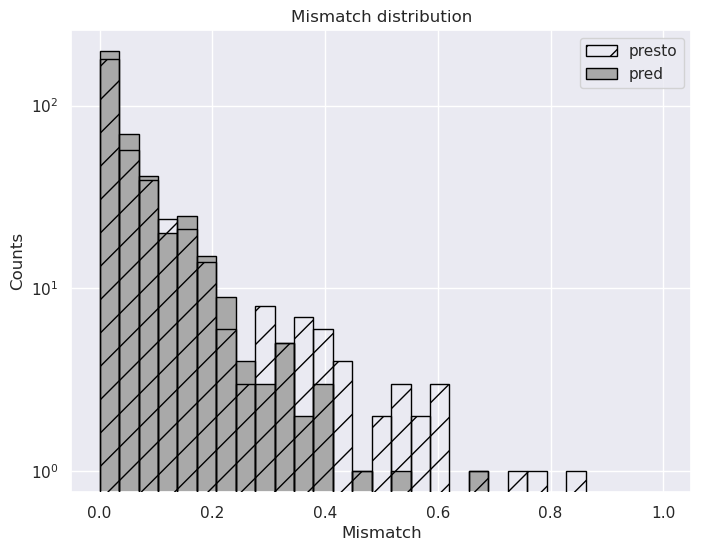

In [74]:
# Define the base color
base_color = 'skyblue'

# Adjust the darkness level
darker_level = 0.8  # Adjust the value between 0 and 1 for different darkness levels

# Create darker shade of skyblue
darker_skyblue = mcolors.to_rgb(base_color)
darker_skyblue = [x * darker_level for x in darker_skyblue]

a = 'fold_snr_true'
b = 'fold_snr_theory'
mismatch_true = 1-(labels_df_filtered[a]/labels_df_filtered[b])
a = 'fold_snr_presto'
b = 'fold_snr_theory'
mismatch_presto = 1-(labels_df_filtered[a]/labels_df_filtered[b])
a = 'fold_snr_pred'
b = 'fold_snr_theory'
mismatch_pred = 1-(labels_df_filtered[a]/labels_df_filtered[b])
bin_edges = np.linspace(0,1,30)
fig,ax = plt.subplots(figsize=(8,6))
# ax1 = ax.twiny()
accel_diff = np.abs(labels_df_filtered['a'].abs() - labels_df_filtered['a_max'])
ax.set_xlabel('Mismatch')
ax.set_yscale('log')
darker_grey = '0.6'
#ax.hist(mismatch_true,bins=bin_edges,alpha=1,label='true',color=darker_grey,edgecolor='black')
ax.hist(mismatch_presto,bins=bin_edges,fill = False,hatch='/',label='presto',alpha=1,edgecolor='black',zorder=100)
ax.hist(mismatch_pred,bins=bin_edges,color='darkgrey',label='pred',alpha=1,edgecolor='black')
#ax.hist(accel_diff/np.max(accel_diff),alpha=0.4,color='skyblue',bins=bin_edges,label='Relative\ndeviation\nfrom max\nacceleration',zorder=0)

#make x axis log
# ax1.set_yscale('log')
# # no ticks on x axis
# ax1.set_xticks([])

# Set the color of the x-axis ticks
#ax1.tick_params(axis='x', colors=darker_skyblue)
#ax1.set_xlabel('Relative deviation from max acceleration',labelpad=-10,color=darker_skyblue)
ax.set_ylabel('Counts')
# ax.arrow(0.03, 230, 0.9, 0, color='darkgrey', width=2,
#          head_width=20, head_length=0.03, length_includes_head=True)
# ax.text(0, 210, '0', fontsize=12, ha='center', va='bottom',
#         color='black',zorder=200)
# ax.text(1, 210, '1', fontsize=12, ha='center', va='bottom',
#         color='black',zorder=200)
# Create a solid bar outside the plot
plt.legend()
ax.set_title('Mismatch distribution')
plt.savefig('plots/mismatch_hist_true_n_pred.png',dpi=300,bbox_inches='tight')


In [2]:
import json
list_of_dicts = json.load(open('hyperparameter_tuning/cnn/list_of_dicts.json'))

In [15]:
list_of_dicts[0]

{'num_cnn_layers': 4,
 'num_deep_layers': 3,
 'initial_learning_rate': 0.0005,
 'decay_rate': 0.9,
 'batch_size': 1200,
 'index': 0,
 'deep_layer_size': '[64, 128, 256]',
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1],
 'padding': 'same',
 'dilation': False,
 'conv1d_filters': '[64, 128, 256, 512]',
 'conv1d_kernel_size': '[5, 7, 7, 7]',
 'batch_normalization': False}

In [3]:
import pprint
for i in range(1,13):
    pprint.pprint(list_of_dicts[i])

{'batch_normalization': True,
 'batch_size': 400,
 'conv1d_filters': '[136, 272, 408, 544, 680, 816, 952, 1088, 1224, 1360]',
 'conv1d_kernel_size': '[44, 40, 36, 32, 28, 24, 20, 16, 12, 8]',
 'decay_rate': 0.95,
 'deep_layer_size': '[584, 864, 728, 1456, 184, 1016]',
 'dilation': True,
 'dilation_rate_size': '[12, 24, 36, 48, 60, 72, 84, 96, 108, 120]',
 'epochs': 20000,
 'index': 1,
 'initial_learning_rate': 0.00115,
 'input_shape': [400, 1],
 'num_cnn_layers': 10,
 'num_deep_layers': 6,
 'padding': 'valid',
 'patience': 400}
{'batch_normalization': True,
 'batch_size': 400,
 'conv1d_filters': '[1936, 1760, 1584, 1408, 1232, 1056, 880, 704, 528, 352]',
 'conv1d_kernel_size': '[3, 6, 9, 12, 15, 18, 21, 24, 27, 30]',
 'decay_rate': 0.95,
 'deep_layer_size': '[40, 80, 120, 160, 200, 240]',
 'dilation': True,
 'dilation_rate_size': '[154, 42, 86, 168, 44, 14, 8, 152, 52, 120]',
 'epochs': 20000,
 'index': 2,
 'initial_learning_rate': 0.00115,
 'input_shape': [400, 1],
 'num_cnn_layers': 

In [12]:
list_of_dicts[20]

{'num_deep_layers': 2,
 'initial_learning_rate': 0.00021,
 'decay_rate': 0.7,
 'batch_size': 400,
 'num_cnn_layers': 6,
 'padding': 'valid',
 'dilation': True,
 'batch_normalization': False,
 'index': 24,
 'deep_layer_size': '[192, 128]',
 'conv1d_filters': '[112, 224, 336, 448, 560, 672]',
 'conv1d_kernel_size': '[21, 18, 15, 12, 9, 6]',
 'dilation_rate_size': '[6, 12, 18, 24, 30, 36]',
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [13]:
list_of_dicts[18]

{'num_deep_layers': 2,
 'initial_learning_rate': 0.00021,
 'decay_rate': 0.7,
 'batch_size': 400,
 'num_cnn_layers': 6,
 'padding': 'valid',
 'dilation': True,
 'batch_normalization': False,
 'index': 24,
 'deep_layer_size': '[192, 128]',
 'conv1d_filters': '[112, 224, 336, 448, 560, 672]',
 'conv1d_kernel_size': '[21, 18, 15, 12, 9, 6]',
 'dilation_rate_size': '[6, 12, 18, 24, 30, 36]',
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}